# Importing libraries and doing everything related to data preprocessing

In [133]:
!pip install transformers
!pip install emoji
!pip install arabic-reshaper
!pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
import pandas as pd
import numpy as np
import nltk
nltk.download('popular', quiet=True)
from collections import Counter
import re
import string
import torch
from transformers import AutoTokenizer, AutoModel
import emoji
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device(0)

1
Tesla T4


In [135]:
!pip3 freeze > requirements.txt
# cat requirements.txt | xargs -n 1 pip install

# Downloading the WordPiece tokenizer used by MARBERT

In [136]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")

# TextCleaner class to clean text in general and for MARBERT

In [137]:
class TextCleaner:
  def __init__(self, remove_links=True, remove_mentions_and_hashtags=True, 
               replace_emojis_with_meaningful_tokens=True, remove_emojis=False, remove_consecutive_duplicate_letters=True,
               remove_numbers=True, remove_punctuation=True, only_arabic_chars=False, remove_stop_words=True, letters_normalization=True, remove_j_shift= True):
    self.remove_links = remove_links
    self.remove_mentions_and_hashtags = remove_mentions_and_hashtags
    self.replace_emojis_with_meaningful_tokens = replace_emojis_with_meaningful_tokens
    self.remove_emojis = remove_emojis
    self.remove_consecutive_duplicate_letters = remove_consecutive_duplicate_letters
    self.remove_numbers = remove_numbers
    self.remove_punctuation = remove_punctuation
    self.only_arabic_chars = only_arabic_chars
    self.remove_stop_words = remove_stop_words
    self.letters_normalization = letters_normalization
    self.remove_j_shift = remove_j_shift

  
  def clean_text(self, document):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
    
    def delete_consecutive_strings(s):
        i=0
        j=0
        new_elements=''
        while(j<len(s)):
            if( s[i]==s[j] ):
                j+=1
            elif((s[j]!=s[i]) or (j==len(s)-1)):
                new_elements+=s[i]
                i=j
                j+=1
        new_elements+=s[j-1]
        return new_elements
    # Remove URLs
    if self.remove_links:
      document = re.sub('http\S+', '', document)

    # Remove mentions and hashtags
    if self.remove_mentions_and_hashtags:
      document = re.sub('[@#]\w+', '', document)

    # Replacing emojis with meaningful tokens
    if self.replace_emojis_with_meaningful_tokens:
      document = re.sub('[😍❤️❤💜💙🖤💓💗💚💝💘💖💕🤍💛❣️💞🌹🥰💟💑]', ' حبحب ', document)
      document = re.sub('[🐶🐕🐷🐖🐴🐄🐮🐂🐃🐵🐒🙉🐑🐐🐸🦄]', ' حيواناتحيوانات ', document)
      document = re.sub('[😡🤬😠😤🤮🤢😣😷😒🙄]', ' معصبمعصب ', document)
      document = re.sub('[👊👊🏽👊🏻👊🏼👊🏾👊🏿🔪]', ' عنفعنف ', document)
      document = re.sub('[✋✋🏽✋🏻✋🏿✋🏼✋🏾]', ' يديد ', document)
      document = re.sub('[🖕🖕🏽🖕🏻🖕🏿🖕🏼🖕🏾]', ' الوسطىالوسطى ', document)
      document = re.sub('[😂🤣😭💀]', ' ضحكضحك ', document)
      document = re.sub('[💩👠👞]', ' عدماحترامعدماحترام ', document)
      document = re.sub('[😢💔]', ' حزينحزين ', document)
      document = re.sub('🤔', ' يفكريفكر ', document)
      document = re.sub('🔥', ' نارنار ', document)
      document = re.sub('👎', ' عدمإعجابعدمإعجاب ', document)
      #document = emoji_pattern.sub(' إيموجيإيموجي ', document)


    # Remove emojis
    if self.remove_emojis:
      document = emoji_pattern.sub('', document)

    # Remove consecutive duplicate letters
    if self.remove_consecutive_duplicate_letters:
      try:
        document = delete_consecutive_strings(document)
      except:
        pass

    # Remove numbers
    if self.remove_numbers:
      document = re.sub('\d+', '', document)

    # Remove punctuation marks
    if self.remove_punctuation:
      punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~،؟!.؛'
      document = document.translate(str.maketrans('', '', punctuation))


    # # Remove stop words
    if self.remove_stop_words:
      stop_words = nltk.corpus.stopwords.words('arabic')
      stopwords_dict = Counter(stop_words)
      document = ' '.join([word for word in document.split() if word not in stopwords_dict])

    # # Only keep Arabic characters
    if self.only_arabic_chars:
      document = re.sub('[^ء-ي]', ' ', document)

    # Normalize arabic letters
    if self.letters_normalization:
      document = re.sub('[أإءئى]', 'ا', document)
      document = re.sub('ص', 'س', document)
      document = re.sub('ظ', 'ض', document)

    # # Remove ـ
    if self.remove_j_shift:
      document = re.sub('ـ', '', document)

    # # Replacing the multiple spaces between words with 1 space
    document = re.sub(' +', ' ', document)
    document = document.strip()
    return document

  def preprocessing_for_bert(self, data, text_preprocessing_fn=clean_text, MAX_LEN=137):
    try:
      data = data.text.values
    except:
      pass
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")

    for sent in data:
        encoded_sent = tokenizer.encode_plus(text=text_preprocessing_fn(self,sent), add_special_tokens=True, 
                                              max_length=MAX_LEN, padding='max_length', return_attention_mask=True, truncation = True)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# TextStatistics class to show statistics about the corpus passed to its objects

In [138]:
class TextStatistics:
  def __init__(self, cleaning_flag=False, show_word_cloud_chart=True, show_vocab_counts=True, show_sequence_statistics=True, 
               show_emoji_counts=True):
    self.cleaning_flag = cleaning_flag
    self.show_word_cloud_chart = show_word_cloud_chart
    self.show_vocab_counts = show_vocab_counts
    self.show_sequence_statistics = show_sequence_statistics    
    self.show_emoji_counts = show_emoji_counts
  
  def show_statistics(self, df):
    df = df.copy()
    if self.cleaning_flag:
      c1 = TextCleaner(remove_links=True, remove_mentions_and_hashtags=True, 
                       replace_emojis_with_meaningful_tokens=True, remove_emojis=False, remove_consecutive_duplicate_letters=True,
                       remove_numbers=True, remove_punctuation=True, only_arabic_chars=True, remove_stop_words=True, 
                       letters_normalization=True, remove_j_shift= True)
    
    tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")

    vocab = set()
    all_lengths = []
    max_seq_size = -1
    for sentence in df['text']:
      if self.cleaning_flag:
        sentence = c1.clean_text(sentence)
      tokens = tokenizer(sentence)['input_ids']
      all_lengths.append(len(tokens))
      if len(tokens) > max_seq_size:
        max_seq_size = len(tokens)
      
      for word in tokens:
        vocab.add(word)
    
    if self.show_word_cloud_chart:
      df_clean_for_word_cloud_chart = df.copy()
      c2 = TextCleaner(only_arabic_chars=True)
      for i in range(len(df_clean_for_word_cloud_chart)):
        df_clean_for_word_cloud_chart['text'].iloc[i] = c2.clean_text(df_clean_for_word_cloud_chart['text'].iloc[i])
      text = df_clean_for_word_cloud_chart['text'].values
      mask = np.array(Image.open('angry_mask.jpg'))
      wordcloud = WordCloud(mask=mask, background_color='white', max_words=50, contour_color='#FF0000', contour_width=5, colormap='viridis', collocations=False, font_path='alfont_com_Janna-LT-Regular.ttf').generate(str(text))
      wordcloud.to_file('word_cloud_chart.png')
      plt.imshow(wordcloud)
      plt.axis('off')
      plt.show()

    if self.show_vocab_counts:
      print('Vocab size =', len(vocab))
    
    if self.show_sequence_statistics:
      print('Mean =', np.mean(all_lengths))
      print('Median =', np.median(all_lengths))
      print('Max =', np.max(all_lengths))
      print('Min =', np.min(all_lengths))
    
    if self.show_emoji_counts:
      all_emoji_counter = 0
      emojis_counts = {}
      import regex
      def emoji_count(text):
          emoji_counter = 0
          data = regex.findall(r'\X', text)
          for word in data:
              if any(char in emoji.EMOJI_DATA for char in word):
                  emoji_counter += 1
                  if word not in emojis_counts:
                    emojis_counts[word] = 1
                  else:
                    emojis_counts[word] += 1

          return emoji_counter

      for i in range(len(df)):
        all_emoji_counter += emoji_count(df['text'].iloc[i])
      print('Emoji count in corpus =', all_emoji_counter)
      emojis_counts = dict(sorted(emojis_counts.items(), key=lambda item: item[1], reverse=True))
      print(emojis_counts)

# Trying the cleaner class and the tokenizer on random string

In [139]:
c1 = TextCleaner(remove_links=True, remove_mentions_and_hashtags=True, 
                 replace_emojis_with_meaningful_tokens=True, remove_emojis=True, remove_consecutive_duplicate_letters=True,
                 remove_numbers=True, remove_punctuation=True, only_arabic_chars=True, remove_stop_words=True, 
                 letters_normalization=True, remove_j_shift=True)
s='ttrtyhjyhj @user @ahmad حـــــررراااممم [] ______ !!!!!!! ? @ ! ؟ 😋😋 99 💩👎😡🖕🔪🐶 صين طويل https://twitter.com في الشارع و على الطريق طـويل أنـت سـريـع'
print(tokenizer(c1.clean_text(s))['input_ids'])
print(tokenizer(c1.clean_text(s))['attention_mask'])
c1.clean_text(s)

[2, 3815, 4113, 27879, 2453, 8618, 27879, 2453, 4113, 2054, 2980, 8618, 2054, 2980, 71501, 24626, 34780, 1016, 9368, 41799, 5798, 1011, 30676, 5812, 1031, 23210, 90386, 1949, 6854, 6036, 6268, 4335, 6036, 2030, 4481, 3]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


'حرام عدماحترامعدماحترام عدماعجابعدماعجاب معسبمعسب الوسطاالوسطا عنفعنف حيواناتحيوانات سين طويل الشارع الطريق طويل انت سريع'

# Reading the data that we have splitted in another notebook

In [140]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

X_extra = pd.read_csv('X_extra.csv')
y_extra = pd.read_csv('y_extra.csv')

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')

In [141]:
print(X_test.shape, y_test.shape)
X_test = X_test.append(X_extra, ignore_index=True)
y_test = y_test.append(y_extra, ignore_index=True)
print(X_test.shape, y_test.shape)

(4647, 1) (4647, 1)
(4952, 1) (4952, 1)


In [142]:
MAX_LEN = 150

In [143]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_inputs, train_masks = c1.preprocessing_for_bert(data=X_train, MAX_LEN=MAX_LEN)
train_labels = torch.tensor(y_train['label'].values)
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset) # RandomSampler
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_inputs, val_masks = c1.preprocessing_for_bert(X_val, MAX_LEN=MAX_LEN)
val_labels = torch.tensor(y_val['label'].values)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_inputs, test_masks = c1.preprocessing_for_bert(X_test, MAX_LEN=MAX_LEN)
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

# MARBERT and fine-tuning it

In [144]:
import torch.nn as nn
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        hidden_BERT = 768
        hidden_FFNN = 50
        labels_num = 2 # Normal=0, Hate Speech=1

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("UBC-NLP/MARBERTv2")
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_BERT, hidden_FFNN),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_FFNN, labels_num)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [145]:
from transformers import AdamW, get_linear_schedule_with_warmup
def initialize_model(epochs=2):
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()), lr=5e-5, eps=1e-8)

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [146]:
import random
import time

loss_fn = nn.CrossEntropyLoss()
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    print("Start training...\n")
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [147]:
def evaluate(model, val_dataloader):
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [148]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [149]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_metrics(probs, y_true, model_name, dataset_name, test_dataset_name):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC = {roc_auc:0.4f}')
       
    y_pred = np.where(preds >= 0.5, 1, 0)

    print(f'Recall = {recall_score(y_true, y_pred):0.4f}')
    print(f'Precision = {precision_score(y_true, y_pred):0.4f}')
    print(f'F1_score = {f1_score(y_true, y_pred):0.4f}')
    print(f'Accuracy = {accuracy_score(y_true, y_pred):0.4f}')
    

    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()
    
    
    # Plot ROC AUC
    plt.title(f" ROC of {model_name}  trained on {dataset_name} dataset & evaluated on the {test_dataset_name} dataset ")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [150]:
def evaluate_dataset(sents, labels, model_name, dataset_name, test_dataset_name, model):
    test_inputs, test_masks = c1.preprocessing_for_bert(sents)

    # Create the DataLoader for our test set
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
    # Compute predicted probabilities on the test set
    probs = bert_predict(model, test_dataloader)

    # Get predictions from the probabilities
    threshold = 0.5
    preds = np.where(probs[:, 1] > threshold, 1, 0)
    auc_graph = evaluate_metrics(probs, labels, model_name, dataset_name, test_dataset_name)

    return auc_graph

In [151]:
%%time
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at UBC-NLP/MARBERTv2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.467900   |     -      |     -     |   32.77  
   1    |   40    |   0.366792   |     -      |     -     |   29.81  
   1    |   60    |   0.327995   |     -      |     -     |   29.71  
   1    |   80    |   0.320986   |     -      |     -     |   30.20  
   1    |   100   |   0.313747   |     -      |     -     |   29.97  
   1    |   120   |   0.276268   |     -      |     -     |   29.92  
   1    |   140   |   0.234486   |     -      |     -     |   29.94  
   1    |   152   |   0.243516   |     -      |     -     |   17.15  
----------------------------------------------------------------------
   1    |    -    |   0.323880   |  0.228664  |   90.30   |  266.42  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

In [152]:
import pickle
filename = 'MARBERT_Arabic_Phoenix_model.sav'
pickle.dump(bert_classifier, open(filename, 'wb'))

In [153]:
torch.save(bert_classifier, 'MARBERT_Arabic_Phoenix_model.pt')

AUC = 0.9616
Recall = 0.8712
Precision = 0.8442
F1_score = 0.8575
Accuracy = 0.9251


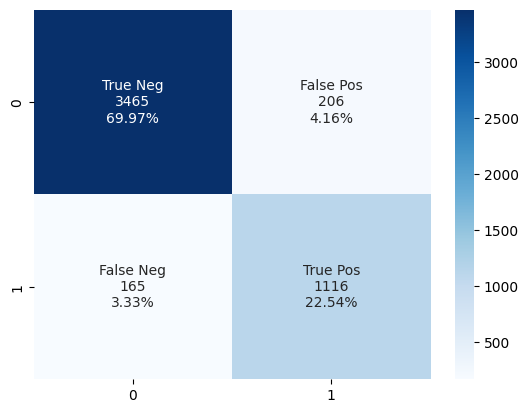

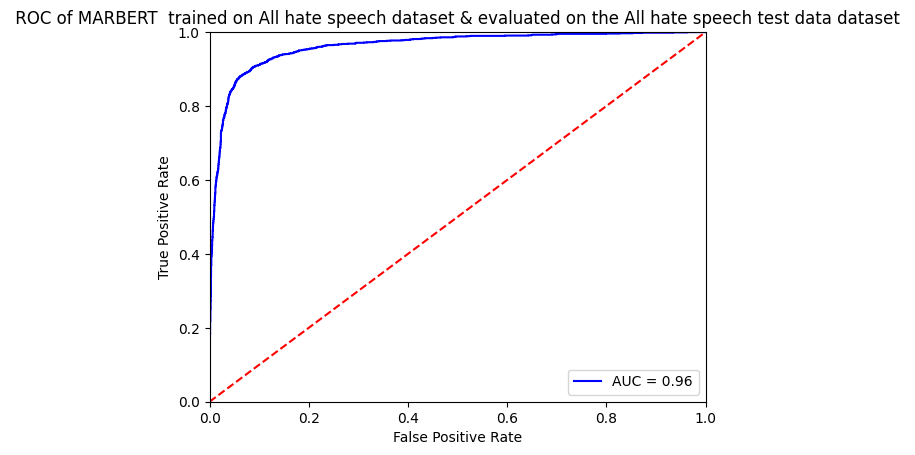

CPU times: user 47.5 s, sys: 593 ms, total: 48.1 s
Wall time: 47.5 s


In [154]:
%%time
evaluate_dataset(X_test, y_test,"MARBERT", "All hate speech", "All hate speech test data", bert_classifier)